In [1]:
#@title Imports
import requests
import pandas as pd
import json
from io import StringIO, BytesIO
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

In [2]:
pd.set_option('display.max_columns', None)

## Find locations within an arbitrary geographic area

We want to target London, UK.

The OpenAQ API accepts coordinates as a WGS84 latitude, longitude pair.

The coordinates for London, UK are 51.5074° N, -0.1278° E.

The radius parameters allows searching around the coordinate point in meters. We will set a 70,000 meter (70km) radius around the central London coordinate (as London's radius is about 70 km)

In [3]:
coordinates = [51.5074,-0.1278]
radius = 4000 # meters

limit = 1000 # number of locations

In [9]:
url = f'https://api.openaq.org/v2/locations?limit={limit}&coordinates={coordinates[0]},{coordinates[1]}&radius={radius}'

In [10]:
response = requests.get(url)
data = response.json()

In [11]:
response.url

'https://api.openaq.org/v2/locations?limit=1000&coordinates=51.5074,-0.1278&radius=4000'

In [12]:
latest = response.json()['results']

In [13]:
len(data['results']) # Number of sensor location

22

In [14]:
data['results']

[{'id': 154,
  'city': 'London',
  'name': 'London Marylebone Road',
  'entity': None,
  'country': 'GB',
  'sources': None,
  'isMobile': False,
  'isAnalysis': None,
  'parameters': [{'id': 1,
    'unit': 'µg/m³',
    'count': 360,
    'average': 10.0,
    'lastValue': 20.0,
    'parameter': 'pm10',
    'displayName': 'pm10 µg/m³',
    'lastUpdated': '2023-06-03T20:00:00+00:00',
    'parameterId': 1,
    'firstUpdated': '2023-05-09T12:00:00+00:00',
    'manufacturers': None},
   {'id': 6,
    'unit': 'µg/m³',
    'count': 612,
    'average': -3.442857142857143,
    'lastValue': 1.0,
    'parameter': 'so2',
    'displayName': 'so2 µg/m³',
    'lastUpdated': '2023-06-03T20:00:00+00:00',
    'parameterId': 6,
    'firstUpdated': '2023-05-08T15:00:00+00:00',
    'manufacturers': None},
   {'id': 5,
    'unit': 'µg/m³',
    'count': 577,
    'average': 41.4,
    'lastValue': 23.0,
    'parameter': 'no2',
    'displayName': 'no2 µg/m³',
    'lastUpdated': '2023-06-03T20:00:00+00:00',
    '

In [15]:
locations = pd.DataFrame.from_dict([{"city": row['city'], "entity":row['entity'], "name":row['name'], 'id': row['id']} for row in data['results']])            

In [16]:
for i in range(len(locations['id'])):
    print(f"{locations['name'][i]}, {locations['id'][i]}")

London Marylebone Road, 154
London Westminster, 159
London Bloomsbury, 148
Westminster - Strand (Northbank BID), 225811
Westminster - Oxford Street East, 225838
Wandsworth - Battersea, 225839
City of London - Farringdon Street, 225743
Lambeth - Bondway Interchange, 225783
Regent Street (The Crown Estate), 927171
City of London - Beech Street, 225731
City of London - Bell Wharf Lane, 225735
Westminster - Elizabeth Bridge, 225801
Westminster - Cavendish Square, 225835
Westminster - Oxford Street, 225848
Waterloo Place (The Crown Estate), 270693
City of London - Guildhall, 304892
Southwark - Elephant and Castle, 225793
Westminster - Covent Garden, 225807
Westminster - Duke Street (Grosvenor), 225833
Southwark - Tower Bridge Road, 225787
Westminster - Ebury Street (Grosvenor), 225846
City of London - The Aldgate School, 225737


## Get measurements for a specific location

To access measurments from OpenAQ we will use the ```/v2/measurements``` endpoint. Theres a number of ways to filter results from the ```/v2/measurements``` but for this example we can query measurements from a single location


Once you have the ```location_id```, you can get data from a single sensor location. We can store the variable here as **location_id**.

To filter the results down to a specific time period of interest we can use the ```data_from=``` and ```date_to=``` parameters. 

Dates must be in the [ISO-8601](https://en.wikipedia.org/wiki/ISO_8601) date time + offset format e.g.```2000-01-01T00:00:00+00:00```, which is January 1 2000 12:00 AM at UTC. 

In [17]:
def analyse(location_id, date_from='2023-05-15T00:00:00+00:00',date_to='2023-06-02T23:59:00+00:00', limit=5000):
    
    params = {
        'location_id': location_id, 
        'date_from': date_from,
        'date_to': date_to,
        'limit': limit
    }
    base_url = 'https://api.openaq.org/v2/measurements'
    response = requests.get(base_url, params=params)
    our_location_data = response.json()
    
    measurements = [{"date": row['date']['local'], "value":row['value'], "parameter":row["parameter"], "unit":row["unit"]} for row in our_location_data['results']]
    df = pd.DataFrame.from_dict(measurements)
    print(df.shape)
    print(df['parameter'].value_counts())
    
    df['date'] = pd.to_datetime(df['date'])
    
    print('Enter the pollutant:')
    x = input()
    pollutant = df[df['parameter'] == x]
    pollutant.set_index('date', inplace=True)
    
    plt.figure(figsize=[16,8])        
    plt.plot(pollutant.index, pollutant['value']) 
    plt.scatter(pollutant.index, pollutant['value'])
    plt.legend([x])       
    plt.xlabel('date')
    plt.ylabel('value')
    plt.title('pm2.5 µg/m³ overtime')
    plt.show()
    
    

Location id: 154, Name: London Marylebone Road
(2303, 4)
so2     450
o3      431
no2     426
co      422
pm25    296
pm10    278
Name: parameter, dtype: int64
Enter the pollutant:
pm10


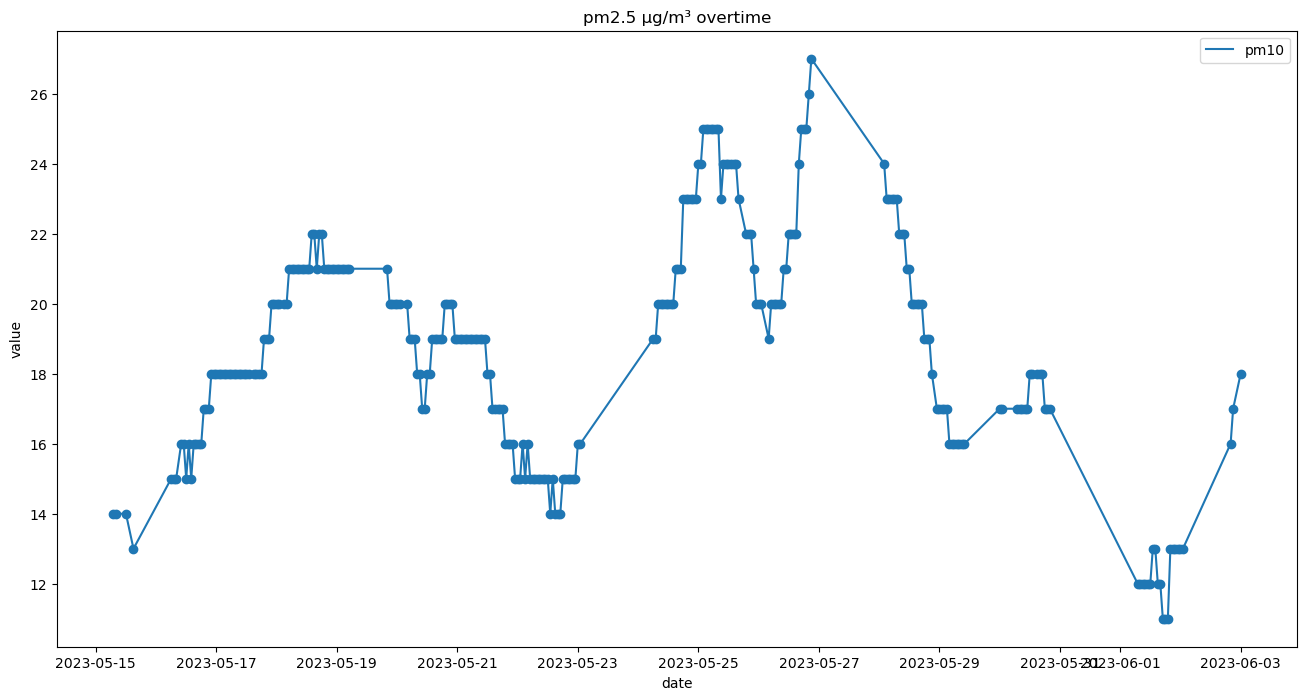

continue [y/n]? 
n


In [18]:
for i in range(len(locations['id'])):
    location_id = locations['id'][i]
    name = locations['name'][i]
    print(f"Location id: {location_id}, Name: {name}")
    analyse(location_id)
    print("continue [y/n]? ")
    x = input()
    if (x != 'y'):
        break;
    

In [19]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

def fetch_measurements(location_id, date_from, date_to, limit=5000):
    """Fetches air quality measurements from the OpenAQ API.

    Args:
        location_id (str): The id of the location to get measurements for.
        date_from (str): The start date in ISO 8601 format.
        date_to (str): The end date in ISO 8601 format.
        limit (int, optional): The maximum number of measurements to fetch. Defaults to 5000.

    Returns:
        DataFrame: The measurements for the given location and date range.
    """
    base_url = 'https://api.openaq.org/v2/measurements'
    params = {
        'location_id': location_id, 
        'date_from': date_from,
        'date_to': date_to,
        'limit': limit
    }

    response = requests.get(base_url, params=params)
    response.raise_for_status()

    data = response.json()['results']
    measurements = [{"date": row['date']['local'], "value":row['value'], "parameter":row["parameter"], "unit":row["unit"]} for row in data]

    df = pd.DataFrame(measurements)
    df['date'] = pd.to_datetime(df['date'])

    return df

def plot_measurements(df, pollutant):
    """Plots the measurements for a given pollutant over time.

    Args:
        df (DataFrame): The measurements to plot.
        pollutant (str): The pollutant to plot.
    """
    df = df[df['parameter'] == pollutant]
    df.set_index('date', inplace=True)
    
    plt.figure(figsize=[16,8])        
    plt.plot(df.index, df['value']) 
    plt.scatter(df.index, df['value'])
    plt.legend([pollutant])       
    plt.xlabel('date')
    plt.ylabel('value')
    plt.title(f'{pollutant} µg/m³ overtime')
    plt.show()

def analyse(location_id, date_from='2023-05-15T00:00:00+00:00',date_to='2023-06-02T23:59:00+00:00', limit=5000):
    """Fetches measurements and plots them for a given location and date range.

    Args:
        location_id (str): The id of the location to get measurements for.
        date_from (str): The start date in ISO 8601 format.
        date_to (str): The end date in ISO 8601 format.
        limit (int, optional): The maximum number of measurements to fetch. Defaults to 5000.
    """
    df = fetch_measurements(location_id, date_from, date_to, limit)

    print(df['parameter'].value_counts())

    pollutant = input('Enter the pollutant: ')
    if pollutant not in df['parameter'].unique():
        print(f'Invalid pollutant. Available options are {df["parameter"].unique()}')
        return

    plot_measurements(df, pollutant)


In [ ]:
for i in range(len(locations['id'])):
    location_id = locations['id'][i]
    name = locations['name'][i]
    print(f"Location id: {location_id}, Name: {name}")
    analyse(location_id)
    print("continue [y/n]? ")
    x = input()
    if (x != 'y'):
        break;
    